In [75]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/캡스톤/거시경제및커피가격통합데이터.csv")

In [76]:
df['abs_return'] = df['Coffee_Price_Return'].abs()

# 5일, 10일 변동성 (rolling std)
df['volatility_5d'] = df['Coffee_Price_Return'].rolling(window=5).std()
df['volatility_10d'] = df['Coffee_Price_Return'].rolling(window=10).std()

# 5일 평균 수익률
df['momentum_5d'] = df['Coffee_Price'] - df['Coffee_Price'].shift(5)

# Bollinger Band Width (상대 변동성)
rolling_mean = df['Coffee_Price'].rolling(window=20).mean()
rolling_std = df['Coffee_Price'].rolling(window=20).std()
df['bollinger_width'] = (2 * rolling_std) / rolling_mean

# Return Z-score (비정상 변동 탐지)
df['return_zscore'] = (df['Coffee_Price_Return'] - df['Coffee_Price_Return'].rolling(20).mean()) / \
                       (df['Coffee_Price_Return'].rolling(20).std() + 1e-6)

df['momentum_1d'] = df['Coffee_Price'].diff(1)
df['momentum_3d'] = df['Coffee_Price'].diff(3)
df['volatility_ratio'] = df['volatility_5d'] / df['volatility_10d']

In [77]:
we = pd.read_csv("/content/drive/MyDrive/캡스톤/기후데이터피쳐선택.csv")

In [78]:
we.drop(columns=['Coffee_Price'], inplace=True)

In [79]:
df = pd.merge(df, we, on='Date', how='left')

In [80]:
df = df.dropna()

In [81]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [82]:
len(df)

2393

In [83]:
n = len(df)
train_size = int(n * 0.7)
val_size = int(n * 0.1)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size : train_size + val_size]
test_df = df.iloc[train_size + val_size:]

In [84]:
from sklearn.preprocessing import MinMaxScaler
# price_train = train_df["Coffee_Price"].copy()
# price_val = val_df["Coffee_Price"].copy()
# price_test = test_df["Coffee_Price"].copy()

return_train = train_df["Coffee_Price_Return"].copy()
return_val = val_df["Coffee_Price_Return"].copy()
return_test = test_df["Coffee_Price_Return"].copy()

scaler_seq = MinMaxScaler()
train_df = pd.DataFrame(scaler_seq.fit_transform(train_df),
                        columns=train_df.columns,
                        index=train_df.index)
# train_df["Coffee_Price"] = price_train
train_df["Coffee_Price_Return"] = return_train

val_df = pd.DataFrame(scaler_seq.fit_transform(val_df),
                        columns=val_df.columns,
                        index=val_df.index)
# val_df["Coffee_Price"] = price_val
val_df["Coffee_Price_Return"] = return_val

test_df = pd.DataFrame(scaler_seq.fit_transform(test_df),
                        columns=test_df.columns,
                        index=test_df.index)
test_df["Coffee_Price_Return"] = return_test
# test_df["Coffee_Price"] = price_test

In [85]:
import numpy as np
import torch
from torch.utils.data import Dataset

class MultiStepTimeSeriesDataset(Dataset):
    def __init__(self, dataset, target, data_window, target_size, step, single_step=False):
        self.data, self.labels = [], []

        start_index = data_window
        end_index = len(dataset) - target_size  # 미래 예측을 고려해 끝점 조정

        for i in range(start_index, end_index):
            indices = range(i - data_window, i, step)  # X 데이터 생성 (샘플링 적용)
            self.data.append(dataset[indices])

            if single_step:
                self.labels.append(target[i + target_size])  # 단일 값 예측
            else:
                self.labels.append(target[i:i + target_size])  # 다중 스텝 예측

        # 리스트를 PyTorch Tensor로 변환
        self.data = torch.tensor(np.array(self.data), dtype=torch.float32)
        self.labels = torch.tensor(np.array(self.labels), dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [86]:
X_train = train_df.values
target_col = "Coffee_Price"
y_train = train_df[target_col].values

X_val = val_df.values
y_val = val_df[target_col].values

X_test = test_df.values
y_test = test_df[target_col].values

In [87]:
data_window = 50  # 최근 데이터를 입력으로 사용
future_target = 14  # 14개 미래 값 예측
step = 1  # 단위로 샘플링
train_dataset = MultiStepTimeSeriesDataset(X_train, y_train, data_window, future_target, step)
val_dataset = MultiStepTimeSeriesDataset(X_val, y_val, data_window, future_target, step)
test_dataset = MultiStepTimeSeriesDataset(X_test, y_test, data_window, future_target, step)

LSTM 입력을 위해 3D 배열로 변경

In [88]:
X_train = train_dataset.data
y_train = train_dataset.labels

X_val = val_dataset.data
y_val = val_dataset.labels

In [89]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [17]:
import torch.nn as nn
import torch.optim as optim

In [19]:
pip install entmax

In [138]:
from entmax import Entmax15

class EntmaxAttention(nn.Module):
    def __init__(self, hidden_size, attn_dim=32):
        super().__init__()
        self.score_layer = nn.Sequential(
            nn.Linear(hidden_size, attn_dim),
            nn.Tanh(),
            nn.Linear(attn_dim, 1)
        )
        self.entmax = Entmax15(dim=1)

    def forward(self, lstm_output):
        # lstm_output: (B, T, H)
        scores = self.score_layer(lstm_output).squeeze(-1)  # (B, T)
        weights = self.entmax(scores)  # sparse attention weights
        context = torch.sum(lstm_output * weights.unsqueeze(-1), dim=1)  # (B, H)
        return context, weights

In [139]:
class AttentionLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, target_size=14, dropout=0.4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target_size = target_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.attention = EntmaxAttention(hidden_size)

        # Gating layer to mix context and last_hidden
        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

        # Nonlinear prediction head
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, target_size)
        )

    def forward(self, x, hidden_states=None):
        batch_size = x.size(0)

        if hidden_states is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            hidden_states = (h0, c0)

        lstm_out, _ = self.lstm(x, hidden_states)  # (B, T, H)

        context, attn_weights = self.attention(lstm_out)  # (B, H)
        last_hidden = lstm_out[:, -1, :]  # (B, H)

        # Gated fusion of context and last hidden
        combined = torch.cat([context, last_hidden], dim=1)  # (B, 2H)
        alpha = self.gate(combined)  # (B, 1)
        fused = alpha * context + (1 - alpha) * last_hidden  # (B, H)

        out = self.fc(fused)  # (B, target_size)

        return out, attn_weights

#### 기본 학습 모델

In [140]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size = X_train.shape[2]
target_size = 14
model = AttentionLSTMModel(input_size=input_size, target_size=target_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10)

In [141]:
num_epochs = 80

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x_batch)

        if y_pred.ndim == 3 and y_pred.shape[-1] == 1:
            y_pred = y_pred.squeeze(-1)

        loss = criterion(y_pred, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            y_val_pred, _ = model(x_val)
            if y_val_pred.ndim == 3 and y_val_pred.shape[-1] == 1:
                y_val_pred = y_val_pred.squeeze(-1)

            val_loss += criterion(y_val_pred, y_val).item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch [1/80] | Train Loss: 0.1379 | Val Loss: 0.2463
Epoch [2/80] | Train Loss: 0.0939 | Val Loss: 0.1924
Epoch [3/80] | Train Loss: 0.0688 | Val Loss: 0.1499
Epoch [4/80] | Train Loss: 0.0629 | Val Loss: 0.1513
Epoch [5/80] | Train Loss: 0.0538 | Val Loss: 0.1251
Epoch [6/80] | Train Loss: 0.0347 | Val Loss: 0.0560
Epoch [7/80] | Train Loss: 0.0330 | Val Loss: 0.0715
Epoch [8/80] | Train Loss: 0.0277 | Val Loss: 0.0282
Epoch [9/80] | Train Loss: 0.0465 | Val Loss: 0.1252
Epoch [10/80] | Train Loss: 0.0310 | Val Loss: 0.0430
Epoch [11/80] | Train Loss: 0.0239 | Val Loss: 0.0473
Epoch [12/80] | Train Loss: 0.0206 | Val Loss: 0.0368
Epoch [13/80] | Train Loss: 0.0186 | Val Loss: 0.0234
Epoch [14/80] | Train Loss: 0.0234 | Val Loss: 0.0838
Epoch [15/80] | Train Loss: 0.0250 | Val Loss: 0.0805
Epoch [16/80] | Train Loss: 0.0230 | Val Loss: 0.0234
Epoch [17/80] | Train Loss: 0.0344 | Val Loss: 0.0643
Epoch [18/80] | Train Loss: 0.0237 | Val Loss: 0.0384
Epoch [19/80] | Train Loss: 0.0164 | 

In [142]:
print("y_pred mean:", y_pred.mean().item())
print("y_batch mean:", y_batch.mean().item())

y_pred mean: 0.745121419429779
y_batch mean: 0.7740118503570557


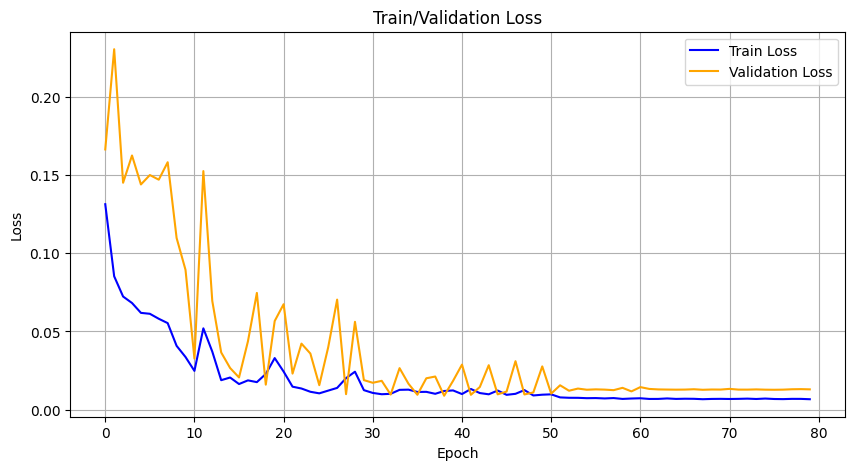

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
model.eval()
predictions = []
prediction_dates_list = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        x_input, _ = test_dataset[i]
        x_input = x_input.unsqueeze(0).to(device)

        y_pred, _ = model(x_input)
        y_pred = y_pred.squeeze().cpu().numpy().reshape(-1, 1)

        # 역변환
        dummy = np.zeros((future_target, test_df.shape[1] - 1))
        combined = np.concatenate([y_pred, dummy], axis=1)
        y_inv = scaler_seq.inverse_transform(combined)[:, 0]

        # test_df에서 해당 시점의 실제 위치를 찾고, df 전체 인덱스로 변환
        base_test_index = i * step + data_window
        if base_test_index + future_target >= len(test_df):
            break

        start_timestamp = test_df.index[base_test_index]
        start_pos_in_df = df.index.get_loc(start_timestamp)

        date_range = df.index[start_pos_in_df + 1 : start_pos_in_df + 1 + future_target]
        if len(date_range) != future_target:
            continue

        predictions.append(pd.Series(y_inv, index=date_range))
        prediction_dates_list.extend(date_range)

In [144]:
all_preds = pd.concat(predictions)
print("Min prediction:", all_preds.min())
print("Max prediction:", all_preds.max())

Min prediction: 172.05955769121647
Max prediction: 208.2414273619652


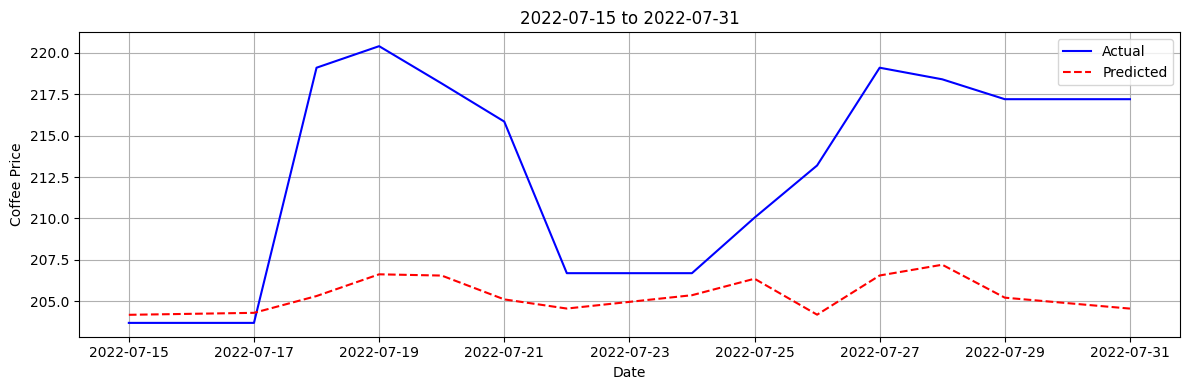

In [145]:
k = 2
pred_k = predictions[k]
start_date = pred_k.index[0]
end_date = pred_k.index[-1]
true_k = df[target_col].loc[start_date:end_date]

plt.figure(figsize=(12, 4))
plt.plot(true_k.index, true_k.values, label='Actual', color='blue')
plt.plot(pred_k.index, pred_k.values, label='Predicted', color='red', linestyle='dashed')
plt.title(f"{start_date.date()} to {end_date.date()}")
plt.xlabel("Date")
plt.ylabel("Coffee Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 잔차 학습 모델

In [263]:
import math
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch import nn, Tensor

class PositionalEncoding(nn.Module):

    def __init__(
        self,
        dropout: float=0.1,
        max_len: int=144,
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model
                     (Vaswani et al, 2017)
        """

        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or
               [enc_seq_len, batch_size, dim_val]
        """
        x = x + self.pe[:x.size(self.x_dim)]
        return self.dropout(x)

In [264]:
class input_embedding(nn.Module):
    def __init__(self,input_size,d_model):
        super(input_embedding,self).__init__()
        self.encoder_input_layer = nn.Linear(
            in_features=input_size,
            out_features=d_model
        )

    def forward(self,x):
        x=self.encoder_input_layer(x)
        return x

In [265]:
class PositionWise(nn.Module):
    def __init__(self,d_model,d_ff):
        super().__init__()
        self.w_1 = nn.Linear(d_model,d_ff)
        self.relu = nn.ReLU()
        self.w_2 = nn.Linear(d_ff,d_model)

    def forward(self, x):
        # Linear Layer1
        x = self.w_1(x)

        # ReLU
        x = self.relu(x)

        # Linear Layer2
        x = self.w_2(x)

        return x

In [266]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, head, d_ff, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model,head)
        self.layerNorm1 = nn.LayerNorm(d_model)

        self.ffn = PositionWise(d_model,d_ff)
        self.layerNorm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):  # (self, x, padding_mask)
        # residual connection을 위해 잠시 담아둔다.
        residual = x

        # 1. multi-head attention (self attention)
        x, attention_score = self.attention(q=x, k=x, v=x) # (q=x, k=x, v=x, mask=padding_mask)

        # 2. add & norm
        x = self.dropout(x) + residual
        x = self.layerNorm1(x)

        residual = x

        # 3. feed-forward network
        x = self.ffn(x)

        # 5. add & norm
        x = self.dropout(x) + residual
        x = self.layerNorm2(x)

        return x, attention_score

In [267]:
class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None):
        # scaling에 필요한 head_dim 값 얻기
        # (batch_size, head, seq_len, head_dim)
        _, _, _, head_dim = q.size()

        # 1. K를 transpose하기 (seq_len, head_dim의 행렬 전환)
        k_t = k.transpose(-1,-2)

        # 2. Q 와 K^T 의 MatMul
        # (batch_size, head, q_seq_len, k_seq_len)
        attention_score = torch.matmul(q,k_t)

        # 3. Scaling
        attention_score /= math.sqrt(head_dim)

        # 4. Mask가 있다면 마스킹된 부위 -1e10으로 채우기
        # mask는 단어가 있는 곳(True), 마스킹된 곳(False)으로 표시되었기 때문에 False(0)에 해당되는 부분을 -1e10으로 masking out한다.
        # Tensor.masked_fill_(mask_boolean, value) 함수는 True값을 value로 채운다.
        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0,-1e10)

        # 5. Softmax 취하기
        attention_score = self.softmax(attention_score)

        # 6. Attention 결과와 V의 MatMul 계산하기
        result = torch.matmul(attention_score, v)

        return result, attention_score

In [268]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,head):
        super().__init__()
        self.d_model = d_model
        self.head = head
        self.head_dim = d_model // head
        self.w_q = nn.Linear(d_model,d_model)
        self.w_k = nn.Linear(d_model,d_model)
        self.w_v = nn.Linear(d_model,d_model)
        self.w_o = nn.Linear(d_model,d_model)
        self.attention = ScaleDotProductAttention()

    def forward(self, q, k, v, mask=None):
        #  [batch_size, seq_len, d_model]
        batch_size, _, _ = q.size()

        # 1. Q,K,V를  d_k, d_k, d_v 차원으로 projection
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. Q,K,V를 head 수 만큼 분리해주기
        # (batch_size, seq_len, d_model)
        # -> (batch_size, head, seq_len, head_dim)
        # 디코더에서는 q와 k,v 의 seq_len 가 다른 경우가 올 수 있음
        q = q.view(batch_size, -1, self.head, self.head_dim).transpose(1,2)
        k = k.view(batch_size, -1, self.head, self.head_dim).transpose(1,2)
        v = v.view(batch_size, -1, self.head, self.head_dim).transpose(1,2)

        # 3. Scaled Dot-Product Attention 을 수행하기
        out, attention_score = self.attention(q,k,v,mask)

        # 4. 분리된 head들을 concat 하기
        # (batch_size, head, seq_len, head_dim)
        # -> (batch_size, seq_len, d_model)
        out = out.transpose(1,2).contiguous().view(batch_size, -1, self.d_model)

        # 5. d_model 차원으로 projection
        out = self.w_o(out)

        return out, attention_score

In [292]:
class ResidualTransformer(nn.Module):
    def __init__(self, input_size, output_size=14, d_model=64, head=4, d_ff=128, max_len=144, dropout=0.1, n_layers=3):
        super().__init__()

        # Input embedding
        self.input_emb = input_embedding(input_size=input_size, d_model=d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model=d_model, max_len=max_len, dropout=dropout)

        # Stacked Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model=d_model, head=head, d_ff=d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.attn_pooling = nn.Sequential(
            nn.Linear(d_model, 1),
            nn.Softmax(dim=1)
        )
        # Output projection layers
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_size)
        )

    def forward(self, x):  # x: (B, T, input_size)
        x = self.input_emb(x)                     # (B, T, d_model)
        x = self.pos_encoding(x)                  # (B, T, d_model)

        for encoder_layer in self.encoder_layers:
            x, _ = encoder_layer(x)               # (B, T, d_model)

        attn_weights = self.attn_pooling(x)        # (B, T, 1)
        pooled = torch.sum(x * attn_weights, dim=1)  # (B, d_model)

        out = self.output_head(pooled)             # (B, output_size)
        return out, attn_weights

In [329]:
input_size = X_train.shape[2]
target_size = 14
residual_model = ResidualLSTM(input_size=input_size, output_size=target_size).to(device)
# residual_criterion = nn.MSELoss()

residual_criterion = torch.nn.HuberLoss(delta=0.02)

residual_optimizer = torch.optim.Adam(residual_model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [330]:
num_epochs = 50

train_losses = []
val_losses = []

threshold = 0.01
alpha = 0.5

model.eval()
for epoch in range(num_epochs):
    residual_model.train()
    epoch_loss = 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        with torch.no_grad():
            y_pred1, _ = model(x_batch)

        residual_target = y_batch - y_pred1.detach()
        residual_optimizer.zero_grad()

        y_pred2, _ = residual_model(x_batch)

        if y_pred2.ndim == 3 and y_pred2.shape[-1] == 1:
            y_pred2 = y_pred2.squeeze(-1)

        # error = torch.abs(residual_target)
        # weights = 1.0 + alpha * error
        # loss = ((y_pred2 - residual_target) ** 2 * weights).mean()

        loss = residual_criterion(y_pred2, residual_target)
        loss.backward()
        residual_optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    residual_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            y_val_pred1, _ = model(x_val)  # 고정된 기존 모델 예측
            residual_target_val = y_val - y_val_pred1.detach()

            y_val_pred2, _ = residual_model(x_val)
            if y_val_pred2.ndim == 3 and y_val_pred2.shape[-1] == 1:
                y_val_pred2 = y_val_pred2.squeeze(-1)

            error_val = torch.abs(residual_target_val)
            weights_val = 1.0 + (error_val > threshold).float() * alpha

            val_loss += ((y_val_pred2 - residual_target_val) ** 2 * weights_val).mean().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch [1/50] | Train Loss: 0.0016 | Val Loss: 0.0252
Epoch [2/50] | Train Loss: 0.0014 | Val Loss: 0.0208
Epoch [3/50] | Train Loss: 0.0011 | Val Loss: 0.0173
Epoch [4/50] | Train Loss: 0.0010 | Val Loss: 0.0158
Epoch [5/50] | Train Loss: 0.0010 | Val Loss: 0.0155
Epoch [6/50] | Train Loss: 0.0009 | Val Loss: 0.0153
Epoch [7/50] | Train Loss: 0.0009 | Val Loss: 0.0151
Epoch [8/50] | Train Loss: 0.0009 | Val Loss: 0.0151
Epoch [9/50] | Train Loss: 0.0009 | Val Loss: 0.0151
Epoch [10/50] | Train Loss: 0.0009 | Val Loss: 0.0150
Epoch [11/50] | Train Loss: 0.0009 | Val Loss: 0.0150
Epoch [12/50] | Train Loss: 0.0009 | Val Loss: 0.0151
Epoch [13/50] | Train Loss: 0.0009 | Val Loss: 0.0151
Epoch [14/50] | Train Loss: 0.0009 | Val Loss: 0.0150
Epoch [15/50] | Train Loss: 0.0009 | Val Loss: 0.0151
Epoch [16/50] | Train Loss: 0.0009 | Val Loss: 0.0151
Epoch [17/50] | Train Loss: 0.0009 | Val Loss: 0.0151
Epoch [18/50] | Train Loss: 0.0009 | Val Loss: 0.0151
Epoch [19/50] | Train Loss: 0.0009 | 

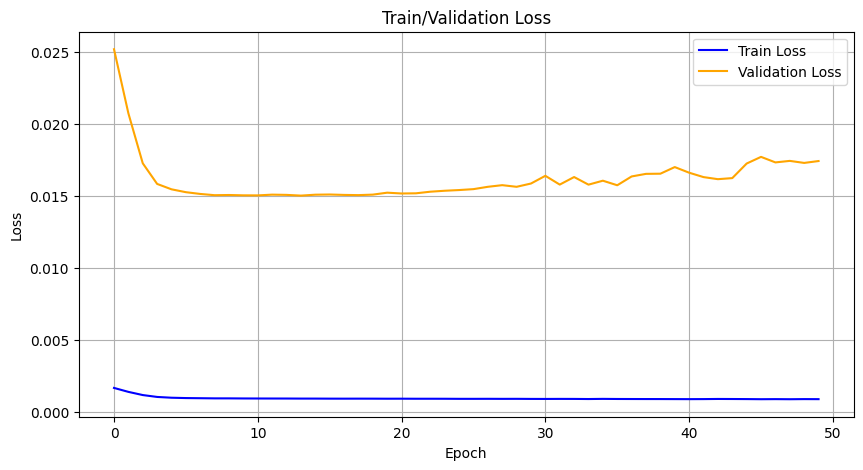

In [331]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [332]:
print('실제 잔차: ', residual_target)
print('예측 잔차: ', y_pred2)

실제 잔차:  tensor([[-0.0079,  0.0246, -0.0416, -0.0566, -0.0351,  0.0102,  0.0023,  0.0074,
         -0.0112,  0.0811,  0.0505,  0.0913,  0.0894,  0.0995],
        [ 0.0152, -0.0200, -0.0392, -0.0582, -0.0086, -0.0038,  0.0226, -0.0029,
          0.0428,  0.0796,  0.1061,  0.0605,  0.0842,  0.0596],
        [-0.0296, -0.0172, -0.0407, -0.0318, -0.0225,  0.0164,  0.0128,  0.0507,
          0.0415,  0.1352,  0.0757,  0.0548,  0.0447,  0.0186],
        [-0.0265, -0.0180, -0.0138, -0.0454, -0.0017,  0.0069,  0.0672,  0.0496,
          0.0977,  0.1052,  0.0708,  0.0155,  0.0046,  0.0176],
        [-0.0278,  0.0088, -0.0277, -0.0251, -0.0115,  0.0610,  0.0660,  0.1051,
          0.0675,  0.0999,  0.0314, -0.0253,  0.0035,  0.0161],
        [-0.0005, -0.0043, -0.0069, -0.0344,  0.0431,  0.0603,  0.1224,  0.0752,
          0.0628,  0.0610, -0.0086, -0.0261,  0.0029, -0.0377],
        [-0.0141,  0.0165, -0.0164,  0.0199,  0.0423,  0.1163,  0.0924,  0.0701,
          0.0238,  0.0207, -0.0094, -0.02

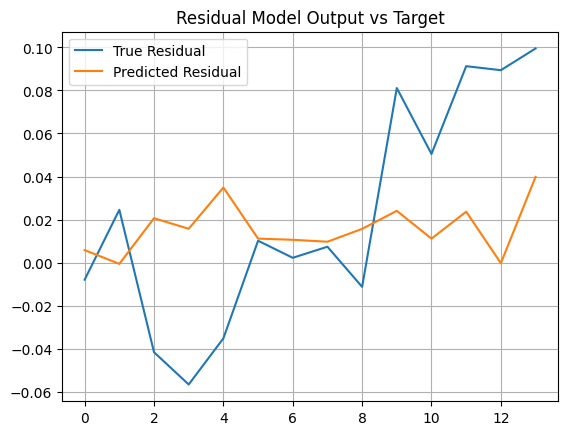

In [333]:
plt.plot(residual_target[0].detach().cpu().numpy(), label="True Residual")
plt.plot(y_pred2[0].detach().cpu().numpy(), label="Predicted Residual")
plt.legend()
plt.title("Residual Model Output vs Target")
plt.grid()
plt.show()

예측 실행

In [334]:
model.eval()
predictions = []
prediction_dates_list = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        x_input, _ = test_dataset[i]
        x_input = x_input.unsqueeze(0).to(device)

        y_pred1, _ = model(x_input)
        y_pred2, _ = residual_model(x_input)

        y_final = y_pred1 + y_pred2  # (1, future_target)
        y_inv = y_final.squeeze().cpu().numpy().flatten()  # (future_target,)

        # 역변환 수행
        dummy = np.zeros((future_target, test_df.shape[1] - 1))
        combined = np.concatenate([y_inv.reshape(-1, 1), dummy], axis=1)
        inv_y = scaler_seq.inverse_transform(combined)[:, 0]

        base_test_index = i * step + data_window
        if base_test_index + future_target >= len(test_df):
            break

        start_timestamp = test_df.index[base_test_index]
        start_pos_in_df = df.index.get_loc(start_timestamp)

        date_range = df.index[start_pos_in_df + 1 : start_pos_in_df + 1 + future_target]
        if len(date_range) != future_target:
            continue

        predictions.append(pd.Series(inv_y, index=date_range))
        prediction_dates_list.extend(date_range)

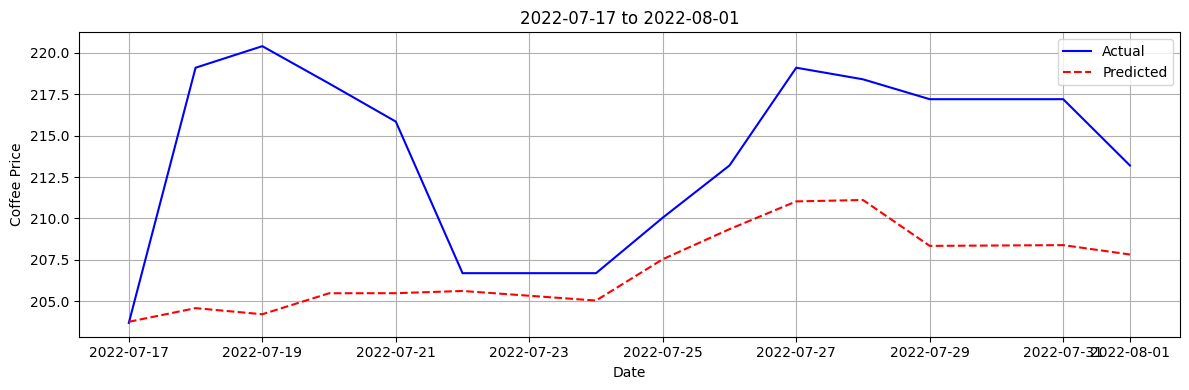

In [325]:
# 특정 인덱스 예측만 보기 (예: 3번째 예측 시퀀스)
import matplotlib.pyplot as plt
k = 3
pred_k = predictions[k]
start_date = pred_k.index[0]
end_date = pred_k.index[-1]
true_k = df[target_col].loc[start_date:end_date]

plt.figure(figsize=(12, 4))
plt.plot(true_k.index, true_k.values, label='Actual', color='blue')
plt.plot(pred_k.index, pred_k.values, label='Predicted', color='red', linestyle='dashed')
plt.title(f"{start_date.date()} to {end_date.date()}")
plt.xlabel("Date")
plt.ylabel("Coffee Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()